Step 1 : Imports



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


False


In [4]:
scaler = GradScaler()


/var/folders/6_/4y_ltkcx34s2r21q8prsrzwm0000gn/T/ipykernel_12395/2535528660.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/sahilpreetsingh/Desktop/OPS/env/lib/python3.14/site-packages/torch/cuda/amp/grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


Step 2 : Dataset Preparation


In [5]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [6]:
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
fashion = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)


In [8]:
def split_dataset(dataset):
    n = len(dataset)
    train_size = int(0.7 * n)
    val_size = int(0.1 * n)
    test_size = n - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size])

mnist_train, mnist_val, mnist_test = split_dataset(mnist)

Step 3: Model Definition

In [9]:
def get_resnet(model_name, num_classes=10):
    if model_name == "resnet18":
        model = models.resnet18(weights=None)
    elif model_name == "resnet50":
        model = models.resnet50(weights=None)

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


Step 4: Training and Validation loops (AMP = ON)

In [10]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast(enabled=True):
            outputs = model(x)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / len(loader), correct / total


Validation/Testing

In [11]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

    return total_loss / len(loader), correct / total


Step 5: Core

In [12]:
def run_experiment(
    model_name,
    dataset,
    batch_size,
    optimizer_name,
    lr,
    epochs,
    pin_memory
):
    train_ds, val_ds, test_ds = dataset

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = get_resnet(model_name)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_acc": [], "val_acc": []}

    for _ in range(epochs):
        _, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        _, val_acc = evaluate(model, val_loader, criterion)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    _, test_acc = evaluate(model, test_loader, criterion)
    return history, test_acc


Step 6: Required Experiments


In [25]:
batch_sizes = [16, 32]
optimizers = ["SGD", "Adam"]
lrs = [0.001, 0.0001]
epochs_list = [10, 20]
pin_memory_vals = [True, False]


In [ ]:
results = []

for bs in batch_sizes:
    for opt in optimizers:
        for lr in lrs:
            history_20, acc_20 = run_experiment(
               "resnet18",
            (mnist_train, mnist_val, mnist_test),
            batch_size=32,
            optimizer_name="Adam",
        lr=0.001,
            epochs=20,
           pin_memory=True
)



Step 7: Graphs

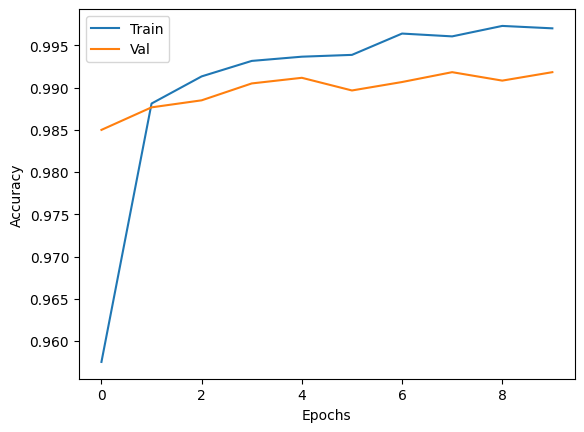

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig("resnet18_mnist_bs16_sgd.png")


Step 8: Table

In [ ]:
df = pd.DataFrame(results, columns=[
    "Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"
])
df


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,MNIST,16,SGD,0.0010,ResNet18,99.258333
1,MNIST,16,SGD,0.0001,ResNet18,98.583333
2,MNIST,16,Adam,0.0010,ResNet18,99.108333
3,MNIST,16,Adam,0.0001,ResNet18,99.333333
4,MNIST,32,SGD,0.0010,ResNet18,99.250000
5,MNIST,32,SGD,0.0001,ResNet18,97.958333
6,MNIST,32,Adam,0.0010,ResNet18,99.183333
7,MNIST,32,Adam,0.0001,ResNet18,99.216667


Picking one of the best configurations and changing epoches on it.

In [ ]:
# Best config identified earlier
best_bs = 32
best_opt = "Adam"
best_lr = 0.001

# 10 epochs
history_10, acc_10 = run_experiment(
    "resnet18",
    (mnist_train, mnist_val, mnist_test),
    batch_size=best_bs,
    optimizer_name=best_opt,
    lr=best_lr,
    epochs=10,
    pin_memory=True
)




/tmp/ipython-input-1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


In [ ]:
best_bs = 32
best_opt = "Adam"
best_lr = 0.001

# 20 epochs
history_20, acc_20 = run_experiment(
    "resnet18",
    (mnist_train, mnist_val, mnist_test),
    batch_size=best_bs,
    optimizer_name=best_opt,
    lr=best_lr,
    epochs=20,
    pin_memory=True
)

/tmp/ipython-input-1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


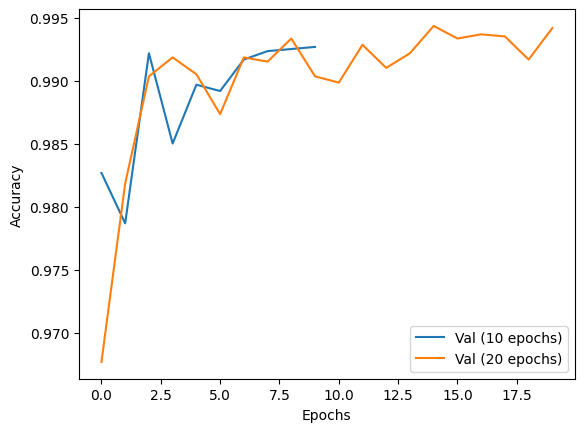

In [ ]:
plt.plot(history_10["val_acc"], label="Val (10 epochs)")
plt.plot(history_20["val_acc"], label="Val (20 epochs)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("epoch_comparison_mnist_resnet18.png")
plt.show()


For ResNet50:-

In [ ]:
print(torch.cuda.is_available())

True


MNIST → ResNet-50

In [14]:
run_configs = [
    (16, "SGD", 0.001),
    (16, "SGD", 0.0001),
]


In [15]:
resnet50_results = []

for bs, opt, lr in run_configs:
    print(f"Running ResNet-50 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(mnist_train, mnist_val, mnist_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    resnet50_results.append([
        "MNIST", bs, opt, lr, "ResNet50", acc * 100
    ])

df_part = pd.DataFrame(
    resnet50_results,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part


Running ResNet-50 | BS=16 | OPT=SGD | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Running ResNet-50 | BS=16 | OPT=SGD | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,MNIST,16,SGD,0.0010,ResNet50,99.116667
1,MNIST,16,SGD,0.0001,ResNet50,98.116667


In [16]:
run_configs = [
    (16, "Adam", 0.001),
    (16, "Adam", 0.0001),
]


In [17]:
resnet50_results = []

for bs, opt, lr in run_configs:
    print(f"Running ResNet-50 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(mnist_train, mnist_val, mnist_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    resnet50_results.append([
        "MNIST", bs, opt, lr, "ResNet50", acc * 100
    ])

df_part = pd.DataFrame(
    resnet50_results,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part


Running ResNet-50 | BS=16 | OPT=Adam | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Running ResNet-50 | BS=16 | OPT=Adam | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,MNIST,16,Adam,0.0010,ResNet50,99.258333
1,MNIST,16,Adam,0.0001,ResNet50,99.058333


In [18]:
run_configs = [
    (32, "SGD", 0.001),
    (32, "SGD", 0.0001),
]


In [19]:
resnet50_results = []

for bs, opt, lr in run_configs:
    print(f"Running ResNet-50 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(mnist_train, mnist_val, mnist_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    resnet50_results.append([
        "MNIST", bs, opt, lr, "ResNet50", acc * 100
    ])

df_part = pd.DataFrame(
    resnet50_results,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part


Running ResNet-50 | BS=32 | OPT=SGD | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Running ResNet-50 | BS=32 | OPT=SGD | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,MNIST,32,SGD,0.0010,ResNet50,98.85
1,MNIST,32,SGD,0.0001,ResNet50,96.90


In [20]:
run_configs = [
    (32, "Adam", 0.001),
    (32, "Adam", 0.0001),
]


In [21]:
resnet50_results = []

for bs, opt, lr in run_configs:
    print(f"Running ResNet-50 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(mnist_train, mnist_val, mnist_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    resnet50_results.append([
        "MNIST", bs, opt, lr, "ResNet50", acc * 100
    ])

df_part = pd.DataFrame(
    resnet50_results,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part


Running ResNet-50 | BS=32 | OPT=Adam | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Running ResNet-50 | BS=32 | OPT=Adam | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,MNIST,32,Adam,0.0010,ResNet50,98.975000
1,MNIST,32,Adam,0.0001,ResNet50,99.316667


In [22]:
import pandas as pd

mnist_resnet50_all = [
    ["MNIST", 16, "Adam", 0.001, "ResNet50", 99.258333],
    ["MNIST", 16, "Adam", 0.0001, "ResNet50", 99.058333],
    ["MNIST", 16, "SGD", 0.001, "ResNet50", 99.116667],
    ["MNIST", 16, "SGD", 0.0001, "ResNet50", 98.116667],

    ["MNIST", 32, "Adam", 0.001, "ResNet50", 98.975000],
    ["MNIST", 32, "Adam", 0.0001, "ResNet50", 99.316667],
    ["MNIST", 32, "SGD", 0.001, "ResNet50", 98.85],
    ["MNIST", 32, "SGD", 0.0001, "ResNet50", 96.90],
]

df_mnist_resnet50 = pd.DataFrame(
    mnist_resnet50_all,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_mnist_resnet50


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,MNIST,16,Adam,0.0010,ResNet50,99.258333
1,MNIST,16,Adam,0.0001,ResNet50,99.058333
2,MNIST,16,SGD,0.0010,ResNet50,99.116667
3,MNIST,16,SGD,0.0001,ResNet50,98.116667
4,MNIST,32,Adam,0.0010,ResNet50,98.975000
5,MNIST,32,Adam,0.0001,ResNet50,99.316667
6,MNIST,32,SGD,0.0010,ResNet50,98.850000
7,MNIST,32,SGD,0.0001,ResNet50,96.900000


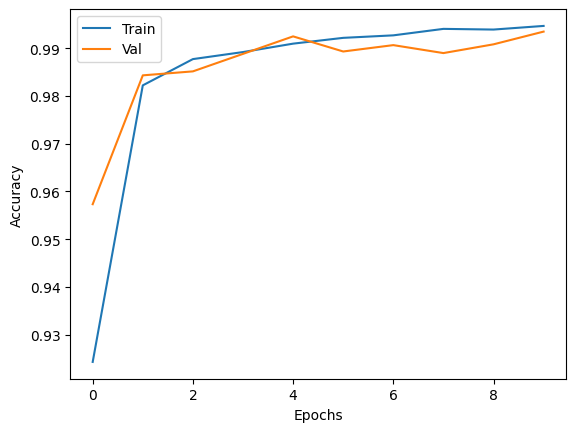

In [24]:
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("resnet50_mnist_best.png")
plt.show()


df_mnist_resnet50.to_csv("mnist_resnet50_results.csv", index=False)


Now running all these for FashionMNIST dataset

In [26]:
run_configs = [
    (16, "SGD", 0.001),
    (16, "SGD", 0.0001),
]


In [27]:

fashion_resnet18_part1 = []

for bs, opt, lr in run_configs:
    print(f"FashionMNIST | ResNet-18 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet18",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet18_part1.append([
        "FashionMNIST", bs, opt, lr, "ResNet18", acc * 100
    ])

df_part1 = pd.DataFrame(
    fashion_resnet18_part1,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part1

FashionMNIST | ResNet-18 | BS=16 | OPT=SGD | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-18 | BS=16 | OPT=SGD | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,16,SGD,0.0010,ResNet18,92.225000
1,FashionMNIST,16,SGD,0.0001,ResNet18,90.141667


In [28]:
df_part1.to_csv("fashion_resnet18_part1.csv", index=False)


In [29]:
run_configs = [
    (16, "Adam", 0.001),
    (16, "Adam", 0.0001),
]

In [30]:
fashion_resnet18_part2 = []

for bs, opt, lr in run_configs:
    print(f"FashionMNIST | ResNet-18 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet18",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet18_part2.append([
        "FashionMNIST", bs, opt, lr, "ResNet18", acc * 100
    ])

df_part2 = pd.DataFrame(
    fashion_resnet18_part2,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part2.to_csv("fashion_resnet18_part2.csv", index=False)
df_part2

FashionMNIST | ResNet-18 | BS=16 | OPT=Adam | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-18 | BS=16 | OPT=Adam | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,16,Adam,0.0010,ResNet18,93.450
1,FashionMNIST,16,Adam,0.0001,ResNet18,93.125


In [32]:
run_configs = [
    (32, "SGD", 0.001),
    (32, "SGD", 0.0001),
]


In [31]:
fashion_resnet18_part3 = []

for bs, opt, lr in run_configs:
    print(f"FashionMNIST | ResNet-18 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet18",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet18_part3.append([
        "FashionMNIST", bs, opt, lr, "ResNet18", acc * 100
    ])

df_part3 = pd.DataFrame(
    fashion_resnet18_part3,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part3.to_csv("fashion_resnet18_part3.csv", index=False)
df_part3

FashionMNIST | ResNet-18 | BS=16 | OPT=Adam | LR=0.001


/tmp/ipykernel_349659/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-18 | BS=16 | OPT=Adam | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,16,Adam,0.0010,ResNet18,92.850000
1,FashionMNIST,16,Adam,0.0001,ResNet18,92.483333


In [1]:
run_configs = [
    (32, "Adam", 0.001),
    (32, "Adam", 0.0001),
]

In [14]:
fashion_resnet18_part4 = []

for bs, opt, lr in run_configs:
    print(f"FashionMNIST | ResNet-18 | BS={bs} | OPT={opt} | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet18",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name=opt,
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet18_part4.append([
        "FashionMNIST", bs, opt, lr, "ResNet18", acc * 100
    ])

df_part4 = pd.DataFrame(
    fashion_resnet18_part4,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_part4.to_csv("fashion_resnet18_part4.csv", index=False)
df_part4

FashionMNIST | ResNet-18 | BS=32 | OPT=Adam | LR=0.001


/tmp/ipykernel_715074/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-18 | BS=32 | OPT=Adam | LR=0.0001


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,32,Adam,0.0010,ResNet18,92.983333
1,FashionMNIST,32,Adam,0.0001,ResNet18,92.333333


In [15]:
df_fashion_resnet18 = pd.concat([
    pd.read_csv("fashion_resnet18_part1.csv"),
    pd.read_csv("fashion_resnet18_part2.csv"),
    pd.read_csv("fashion_resnet18_part3.csv"),
    pd.read_csv("fashion_resnet18_part4.csv"),
], ignore_index=True)

df_fashion_resnet18


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,16,SGD,0.0010,ResNet18,92.225000
1,FashionMNIST,16,SGD,0.0001,ResNet18,90.141667
2,FashionMNIST,16,Adam,0.0010,ResNet18,93.450000
3,FashionMNIST,16,Adam,0.0001,ResNet18,93.125000
4,FashionMNIST,16,Adam,0.0010,ResNet18,92.850000
5,FashionMNIST,16,Adam,0.0001,ResNet18,92.483333
6,FashionMNIST,32,Adam,0.0010,ResNet18,92.983333
7,FashionMNIST,32,Adam,0.0001,ResNet18,92.333333


Table:-

Graphs

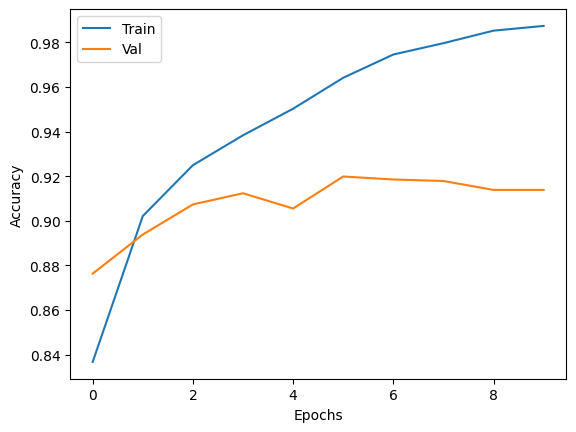

In [16]:
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fashion_resnet18_best.png")
plt.show()


FashionMNIST → ResNet-50 (BEST CONFIGS ONLY)

In [17]:
fashion_resnet50_results = []

for lr in [0.001, 0.0001]:
    print(f"FashionMNIST | ResNet-50 | BS=32 | Adam | LR={lr}")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=32,
        optimizer_name="Adam",
        lr=lr,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet50_results.append([
        "FashionMNIST",
        32,
        "Adam",
        lr,
        "ResNet50",
        acc * 100
    ])


FashionMNIST | ResNet-50 | BS=32 | Adam | LR=0.001


/tmp/ipykernel_715074/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-50 | BS=32 | Adam | LR=0.0001


Table:-

In [18]:
df_fashion_resnet50 = pd.DataFrame(
    fashion_resnet50_results,
    columns=["Dataset", "Batch Size", "Optimizer", "LR", "Model", "Test Accuracy (%)"]
)

df_fashion_resnet50


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,32,Adam,0.0010,ResNet50,92.691667
1,FashionMNIST,32,Adam,0.0001,ResNet50,91.833333


Graph:-

In [ ]:
plt.plot(history["train_acc"], label="Train")
plt.plot(history["val_acc"], label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("fashion_resnet50_best.png")
plt.show()


Fashion Mnist for all

In [11]:
fashion_resnet50_part1 = []

for bs in [16, 32]:
    print(f"FashionMNIST | ResNet-50 | BS={bs} | Adam | LR=0.001")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name="Adam",
        lr=0.001,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet50_part1.append([
        "FashionMNIST", bs, "Adam", 0.001, "ResNet50", acc * 100
    ])

pd.DataFrame(
    fashion_resnet50_part1,
    columns=["Dataset","Batch Size","Optimizer","LR","Model","Test Accuracy (%)"]
).to_csv("fashion_resnet50_part1.csv", index=False)


FashionMNIST | ResNet-50 | BS=16 | Adam | LR=0.001


/tmp/ipykernel_4376/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-50 | BS=32 | Adam | LR=0.001


In [12]:
fashion_resnet50_part2 = []

for bs in [16, 32]:
    print(f"FashionMNIST | ResNet-50 | BS={bs} | Adam | LR=0.0001")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name="Adam",
        lr=0.0001,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet50_part2.append([
        "FashionMNIST", bs, "Adam", 0.0001, "ResNet50", acc * 100
    ])

pd.DataFrame(
    fashion_resnet50_part2,
    columns=["Dataset","Batch Size","Optimizer","LR","Model","Test Accuracy (%)"]
).to_csv("fashion_resnet50_part2.csv", index=False)


FashionMNIST | ResNet-50 | BS=16 | Adam | LR=0.0001


/tmp/ipykernel_4376/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-50 | BS=32 | Adam | LR=0.0001


In [13]:
fashion_resnet50_part3 = []

for bs in [16, 32]:
    print(f"FashionMNIST | ResNet-50 | BS={bs} | SGD | LR=0.001")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name="SGD",
        lr=0.001,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet50_part3.append([
        "FashionMNIST", bs, "SGD", 0.001, "ResNet50", acc * 100
    ])

pd.DataFrame(
    fashion_resnet50_part3,
    columns=["Dataset","Batch Size","Optimizer","LR","Model","Test Accuracy (%)"]
).to_csv("fashion_resnet50_part3.csv", index=False)


FashionMNIST | ResNet-50 | BS=16 | SGD | LR=0.001


/tmp/ipykernel_4376/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-50 | BS=32 | SGD | LR=0.001


In [14]:
fashion_resnet50_part4 = []

for bs in [16, 32]:
    print(f"FashionMNIST | ResNet-50 | BS={bs} | SGD | LR=0.0001")

    history, acc = run_experiment(
        model_name="resnet50",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=bs,
        optimizer_name="SGD",
        lr=0.0001,
        epochs=10,
        pin_memory=True
    )

    fashion_resnet50_part4.append([
        "FashionMNIST", bs, "SGD", 0.0001, "ResNet50", acc * 100
    ])

pd.DataFrame(
    fashion_resnet50_part4,
    columns=["Dataset","Batch Size","Optimizer","LR","Model","Test Accuracy (%)"]
).to_csv("fashion_resnet50_part4.csv", index=False)


FashionMNIST | ResNet-50 | BS=16 | SGD | LR=0.0001


/tmp/ipykernel_4376/1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


FashionMNIST | ResNet-50 | BS=32 | SGD | LR=0.0001


In [19]:
df_fashion_resnet50 = pd.concat([
    pd.read_csv("fashion_resnet50_part1.csv"),
    pd.read_csv("fashion_resnet50_part2.csv"),
    pd.read_csv("fashion_resnet50_part3.csv"),
    pd.read_csv("fashion_resnet50_part4.csv"),
], ignore_index=True)

df_fashion_resnet50


,Dataset,Batch Size,Optimizer,LR,Model,Test Accuracy (%)
0,FashionMNIST,16,Adam,0.0010,ResNet50,92.991667
1,FashionMNIST,32,Adam,0.0010,ResNet50,92.983333
2,FashionMNIST,16,Adam,0.0001,ResNet50,92.858333
3,FashionMNIST,32,Adam,0.0001,ResNet50,92.825000
4,FashionMNIST,16,SGD,0.0010,ResNet50,91.700000
5,FashionMNIST,32,SGD,0.0010,ResNet50,91.108333
6,FashionMNIST,16,SGD,0.0001,ResNet50,88.658333
7,FashionMNIST,32,SGD,0.0001,ResNet50,82.716667


In [ ]:
pin_memory=True vs False (MANDATORY)

In [12]:
import time

pin_memory_results = []

for pm in [True, False]:
    start = time.time()

    history, acc = run_experiment(
        model_name="resnet18",
        dataset=(fashion_train, fashion_val, fashion_test),
        batch_size=32,
        optimizer_name="Adam",
        lr=0.001,
        epochs=10,
        pin_memory=pm
    )

    elapsed = (time.time() - start) * 1000  # ms

    pin_memory_results.append([pm, acc * 100, elapsed])

pin_memory_results


/tmp/ipython-input-1029408469.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


[[True, 93.06666666666666, 1339424.6487617493],
 [False, 92.85833333333333, 1343947.2312927246]]

Question 1 part b 

SVM

In [15]:
import time
import numpy as np
import pandas as pd

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [16]:
def prepare_svm_data(train_ds, test_ds):
    X_train = train_ds.dataset.data.numpy().reshape(len(train_ds.dataset), -1)
    y_train = train_ds.dataset.targets.numpy()

    X_test = test_ds.dataset.data.numpy().reshape(len(test_ds.dataset), -1)
    y_test = test_ds.dataset.targets.numpy()

    return X_train, y_train, X_test, y_test


In [17]:
def run_svm_experiment(X_train, y_train, X_test, y_test, kernel, C=1.0, degree=3):
    svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel=kernel, C=C, degree=degree))
    ])

    start_time = time.time()
    svm.fit(X_train, y_train)
    end_time = time.time()

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred) * 100
    train_time_ms = (end_time - start_time) * 1000

    return acc, train_time_ms


In [20]:
# MNIST (for SVM)
X_mnist_train = mnist_train.dataset.data.numpy().reshape(len(mnist_train.dataset), -1)
y_mnist_train = mnist_train.dataset.targets.numpy()

X_mnist_test = mnist_test.dataset.data.numpy().reshape(len(mnist_test.dataset), -1)
y_mnist_test = mnist_test.dataset.targets.numpy()

# FashionMNIST (for SVM)
X_fashion_train = fashion_train.dataset.data.numpy().reshape(len(fashion_train.dataset), -1)
y_fashion_train = fashion_train.dataset.targets.numpy()

X_fashion_test = fashion_test.dataset.data.numpy().reshape(len(fashion_test.dataset), -1)
y_fashion_test = fashion_test.dataset.targets.numpy()


In [21]:
svm_results = []

for kernel in ["rbf", "poly"]:
    acc, t_ms = run_svm_experiment(
        X_mnist_train, y_mnist_train,
        X_mnist_test, y_mnist_test,
        kernel=kernel
    )

    svm_results.append([
        "MNIST", kernel, acc, t_ms
    ])


In [22]:
for kernel in ["rbf", "poly"]:
    acc, t_ms = run_svm_experiment(
        X_fashion_train, y_fashion_train,
        X_fashion_test, y_fashion_test,
        kernel=kernel
    )

    svm_results.append([
        "FashionMNIST", kernel, acc, t_ms
    ])


In [23]:
df_svm = pd.DataFrame(
    svm_results,
    columns=[
        "Dataset",
        "Kernel",
        "Test Accuracy (%)",
        "Training Time (ms)"
    ]
)

df_svm


,Dataset,Kernel,Test Accuracy (%),Training Time (ms)
0,MNIST,rbf,98.663333,341791.916847
1,MNIST,poly,97.766667,736730.702877
2,FashionMNIST,rbf,92.370000,326469.811678
3,FashionMNIST,poly,91.848333,398622.182846


In [28]:
!pip install thop


In [29]:
import time
import torch
import pandas as pd
from thop import profile


In [30]:
def get_flops(model, device):
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    return flops


In [ ]:
def run_q2_experiment(
    model_name,
    optimizer_name,
    device,
    train_loader,
    val_loader,
    test_loader,
    lr=0.001,
    epochs=5   
):
    model = get_resnet(model_name, num_classes=10).to(device)

    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.CrossEntropyLoss()

    start_time = time.time()

    model.train()
    for _ in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    train_time_ms = (time.time() - start_time) * 1000

    # Test accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    acc = 100 * correct / total

    flops = get_flops(model, device)

    return acc, train_time_ms, flops


In [32]:
def get_loaders(dataset_train, dataset_val, dataset_test, device):
    return (
        torch.utils.data.DataLoader(dataset_train, batch_size=16, shuffle=True),
        torch.utils.data.DataLoader(dataset_val, batch_size=16),
        torch.utils.data.DataLoader(dataset_test, batch_size=16)
    )


In [ ]:
q2_results = []
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 5  


CPU + SGD

In [ ]:
device = torch.device("cpu")
optimizer_name = "SGD"

train_loader, val_loader, test_loader = get_loaders(
    fashion_train, fashion_val, fashion_test, device
)

for model_name in ["resnet18", "resnet50"]:
    print(f"CPU | {model_name} | SGD")

    acc, t_ms, flops = run_q2_experiment(
        model_name=model_name,
        optimizer_name=optimizer_name,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS
    )

    q2_results.append([
        "CPU", BATCH_SIZE, "SGD", LR,
        model_name, acc, t_ms, flops
    ])

pd.DataFrame(q2_results).to_csv("q2_part1_cpu_sgd.csv", index=False)


CPU | resnet18 | SGD
CPU | resnet50 | SGD


In [18]:
device = torch.device("cuda")
optimizer_name = "SGD"

train_loader, val_loader, test_loader = get_loaders(
    fashion_train, fashion_val, fashion_test, device
)

for model_name in ["resnet18", "resnet50"]:
    print(f"GPU | {model_name} | SGD")

    acc, t_ms, flops = run_q2_experiment(
        model_name=model_name,
        optimizer_name=optimizer_name,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS
    )

    q2_results.append([
        "GPU", BATCH_SIZE, "SGD", LR,
        model_name, acc, t_ms, flops
    ])

pd.DataFrame(q2_results).to_csv("q2_part3_gpu_sgd.csv", index=False)


GPU | resnet18 | SGD
GPU | resnet50 | SGD


In [19]:
optimizer_name = "Adam"

for model_name in ["resnet18", "resnet50"]:
    print(f"GPU | {model_name} | Adam")

    acc, t_ms, flops = run_q2_experiment(
        model_name=model_name,
        optimizer_name=optimizer_name,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        epochs=EPOCHS
    )

    q2_results.append([
        "GPU", BATCH_SIZE, "Adam", LR,
        model_name, acc, t_ms, flops
    ])

pd.DataFrame(q2_results).to_csv("q2_part4_gpu_adam.csv", index=False)


GPU | resnet18 | Adam
GPU | resnet50 | Adam


In [18]:
df_q2 = pd.concat([
    # pd.read_csv("q2_part1_cpu_sgd.csv"),
    # pd.read_csv("q2_part2_cpu_adam.csv"),
    # pd.read_csv("q2_part3_gpu_sgd.csv"),
    pd.read_csv("q2_part4_gpu_adam.csv"),
], ignore_index=True)

df_q2


,Compute,Batch_Size,Optimizer,Learning_Rate,Model,Accuracy,Time,FLOPs
0,CPU,16,SGD,0.001,resnet18,86.641667,1.539237e+07,1.823527e+09
1,GPU,16,SGD,0.001,resnet18,86.750000,6.140942e+05,1.823527e+09
2,GPU,16,SGD,0.001,resnet50,81.891667,1.909748e+06,4.131715e+09
3,GPU,16,Adam,0.001,resnet18,92.391667,6.486101e+05,1.823527e+09
4,GPU,16,Adam,0.001,resnet50,91.691667,1.980587e+06,4.131715e+09
